In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
# Import required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,InputLayer
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf

In [4]:
# Import Sentiment140 dataset
# Update file location of Sentiment140.csv according to your working environment

data_path  = "data/training.1600000.processed.noemoticon.csv"

twitter_data = pd.read_csv(data_path,names=['target','id','date','flag','user','text'],
                           encoding = "ISO-8859-1")

In [5]:
# Create NumPy array of unprocessed input text and target 

X=np.array(twitter_data['text'])
Y=np.array(twitter_data['target'])

# Set Y=1 for Positive Tweets
Y[Y==4]=1

In [6]:
# Visualize Dataset

index = 123  # index in range [0,1599999]

print(X[index])

I am in pain. My back and sides hurt. Not to mention crying is made of fail. 


In [7]:
# Define Preprocessing functions

def tokenize(X):
  """
  Tokenize the data using nltk
  """

  treebank = nltk.tokenize.TreebankWordTokenizer()
  X_tokenized=[treebank.tokenize(sentence) for sentence in X]  
  return X_tokenized


def remove_stopwords(X):
  """
  Remove Stopwords using nltk
  """

  stopwords=nltk.corpus.stopwords.words('english') + ['@']
  X_without_stopwords = []

  for sentence in X:

    temp = [word for word in sentence if not word in stopwords]
    X_without_stopwords.append(temp) 

  return X_without_stopwords


def stem(X,type='porter'):
  """
  Perform Stemming using nltk
  type = 'Porter','Snowball','Lancaster'
  """
  
  if type == 'porter':
    stemmer= nltk.stem.PorterStemmer()
  elif type == 'snowball':
    stemmer = nltk.stem.SnowballStemmer()
  elif type == 'lancaster':
    stemmer = nltk.stem.LancasterStemmer()    

  
  X_stemmed = []

  for sentence in X:

    temp = [stemmer.stem(word) for word in sentence]
    X_stemmed.append(temp)

  return X_stemmed 



def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return 'a'
        elif treebank_tag.startswith('V'):
            return 'v'
        elif treebank_tag.startswith('N'):
            return 'n'
        elif treebank_tag.startswith('R'):
            return 'r'
        else:
            return 'n'


def lemmatize(X):
  """
  Lemmatize words using corresponding POS tag
  """

  lemmatizer = nltk.stem.WordNetLemmatizer()
  
  X_pos = []
  X_lemmatized = []

  for sentence in X :

    temp = nltk.pos_tag(sentence)
    X_pos.append(temp)  

  for sentence in X_pos :

    temp = [ lemmatizer.lemmatize(word[0],pos=get_wordnet_pos(word[1])) for word in sentence]
    X_lemmatized.append(temp)  

  return X_lemmatized    

# **Training on Pre-Processed data with GloVe Word Embeddings**



In [8]:
# Preprocess the data

X_tokenized = tokenize (X)

X_without_stopwords = remove_stopwords ( X_tokenized )

X_lemmatized = lemmatize ( X_without_stopwords )

X_clean = []

for sentence in X_lemmatized:

  temp = " ".join(sentence)
  X_clean.append(temp)

In [9]:
# Count total no. of distinct tokens

tokenizer = Tokenizer(filters='@')
tokenizer.fit_on_texts(X_clean)

print('No. of distinct tokens = '+str(len(tokenizer.word_index)))

No. of distinct tokens = 836890


In [10]:
# Define Vocabulary size (no. of most frequent tokens) to consider

max_vocab=50000

In [11]:
# Reload Twitter dataset with new Vocabulary

tokenizer = Tokenizer(num_words=max_vocab,filters='@')
tokenizer.fit_on_texts(X_clean)

In [12]:
# Vectorize input text using Vocabulary

X_clean_vectorized=tokenizer.texts_to_sequences(X_clean)

In [13]:
# Count average length of tweets

length=[]
for sentence in X_clean_vectorized:
  length.append(len(sentence))
  
print('Average length of tweets = '+str(np.mean(length)))

Average length of tweets = 10.061133125


In [14]:
# Define Maximum input length of the Model

max_length=20

In [15]:
# Pad or Trim data to defined input length

X_clean_pad = keras.preprocessing.sequence.pad_sequences(X_clean_vectorized,max_length,padding='post',
                                                         truncating='post')

print(X_clean_pad.shape)

(1600000, 20)


In [16]:
# Visualize pre-processed data

index  = 123  # index in range [0,1599999]

print('\nOriginal :')
print(X[index])
print('\nTokenized :')
print(X_tokenized[index])
print('\nStopwords removed :')
print(X_without_stopwords[index])
print('\nPOS tagged :')
print(nltk.pos_tag(X_without_stopwords[index]))
print('\nLemmatized :')
print(X_lemmatized[index])
print('\nClean :')
print(X_clean[index])
print('\nVectorized :')
print(X_clean_vectorized[index])
print('\nPadded :')
print(X_clean_pad[index])


Original :
I am in pain. My back and sides hurt. Not to mention crying is made of fail. 

Tokenized :
['I', 'am', 'in', 'pain.', 'My', 'back', 'and', 'sides', 'hurt.', 'Not', 'to', 'mention', 'crying', 'is', 'made', 'of', 'fail', '.']

Stopwords removed :
['I', 'pain.', 'My', 'back', 'sides', 'hurt.', 'Not', 'mention', 'crying', 'made', 'fail', '.']

POS tagged :
[('I', 'PRP'), ('pain.', 'VBP'), ('My', 'PRP$'), ('back', 'NN'), ('sides', 'NNS'), ('hurt.', 'VBP'), ('Not', 'RB'), ('mention', 'NN'), ('crying', 'VBG'), ('made', 'VBN'), ('fail', 'NN'), ('.', '.')]

Lemmatized :
['I', 'pain.', 'My', 'back', 'side', 'hurt.', 'Not', 'mention', 'cry', 'make', 'fail', '.']

Clean :
I pain. My back side hurt. Not mention cry make fail .

Vectorized :
[2, 3428, 62, 30, 591, 4229, 146, 831, 308, 33, 426, 4]

Padded :
[   2 3428   62   30  591 4229  146  831  308   33  426    4    0    0
    0    0    0    0    0    0]


In [17]:
# Perform train-test split

np.random.seed(123)

X_train, X_test, Y_train, Y_test = train_test_split (X_clean_pad,Y.reshape(Y.shape[0],1),test_size=0.1)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1440000, 20)
(160000, 20)
(1440000, 1)
(160000, 1)


In [65]:
vocab_size = 5000  # Only consider the top 20k words
num_tokens_per_example = 20 
embed_dim = 32  # Embedding size for each token.
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feedforward network.
num_experts = 10  # Number of experts used in the Switch Transformer.
batch_size = 32  # Batch size.
learning_rate = 0.001  # Learning rate.
dropout_rate = 0.25  # Dropout rate.
num_epochs = 25  # Number of epochs.
num_tokens_per_batch = (
    batch_size * num_tokens_per_example
)  # Total number of tokens per batch.
print(f"Number of tokens per batch: {num_tokens_per_batch}")


Number of tokens per batch: 640


In [131]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    def get_config(self):
        return super(TokenAndPositionEmbedding,self).get_config()

In [132]:
def create_feedforward_network(ff_dim, name=None):
    return keras.Sequential(
        [layers.Dense(ff_dim, activation="relu"), layers.Dense(ff_dim)], name=name
    )

In [133]:
def load_balanced_loss(router_probs, expert_mask):
    # router_probs [tokens_per_batch, num_experts] is the probability assigned for
    # each expert per token. expert_mask [tokens_per_batch, num_experts] contains
    # the expert with the highest router probability in one−hot format.

    num_experts = tf.shape(expert_mask)[-1]
    # Get the fraction of tokens routed to each expert.
    # density is a vector of length num experts that sums to 1.
    density = tf.reduce_mean(expert_mask, axis=0)
    # Get fraction of probability mass assigned to each expert from the router
    # across all tokens. density_proxy is a vector of length num experts that sums to 1.
    density_proxy = tf.reduce_mean(router_probs, axis=0)
    # Want both vectors to have uniform allocation (1/num experts) across all
    # num_expert elements. The two vectors will be pushed towards uniform allocation
    # when the dot product is minimized.
    loss = tf.reduce_mean(density_proxy * density) * tf.cast(
        (num_experts ** 2), tf.dtypes.float32
    )
    return loss

In [134]:
class Router(layers.Layer):
    def __init__(self, num_experts, expert_capacity):
        self.num_experts = num_experts
        self.route = layers.Dense(units=num_experts)
        self.expert_capacity = expert_capacity
        super(Router, self).__init__()

    def call(self, inputs, training=False):
        # inputs shape: [tokens_per_batch, embed_dim]
        # router_logits shape: [tokens_per_batch, num_experts]
        router_logits = self.route(inputs)

        if training:
            # Add noise for exploration across experts.
            router_logits += tf.random.uniform(
                shape=router_logits.shape, minval=0.9, maxval=1.1
            )
        # Probabilities for each token of what expert it should be sent to.
        router_probs = keras.activations.softmax(router_logits, axis=-1)
        # Get the top−1 expert for each token. expert_gate is the top−1 probability
        # from the router for each token. expert_index is what expert each token
        # is going to be routed to.
        expert_gate, expert_index = tf.math.top_k(router_probs, k=1)
        # expert_mask shape: [tokens_per_batch, num_experts]
        expert_mask = tf.one_hot(expert_index, depth=self.num_experts)
        # Compute load balancing loss.
        aux_loss = load_balanced_loss(router_probs, expert_mask)
        self.add_loss(aux_loss)
        # Experts have a fixed capacity, ensure we do not exceed it. Construct
        # the batch indices, to each expert, with position in expert make sure that
        # not more that expert capacity examples can be routed to each expert.
        position_in_expert = tf.cast(
            tf.math.cumsum(expert_mask, axis=0) * expert_mask, tf.dtypes.int32
        )
        # Keep only tokens that fit within expert capacity.
        expert_mask *= tf.cast(
            tf.math.less(
                tf.cast(position_in_expert, tf.dtypes.int32), self.expert_capacity
            ),
            tf.dtypes.float32,
        )
        expert_mask_flat = tf.reduce_sum(expert_mask, axis=-1)
        # Mask out the experts that have overflowed the expert capacity.
        expert_gate *= expert_mask_flat
        # Combine expert outputs and scaling with router probability.
        # combine_tensor shape: [tokens_per_batch, num_experts, expert_capacity]
        combined_tensor = tf.expand_dims(
            expert_gate
            * expert_mask_flat
            * tf.squeeze(tf.one_hot(expert_index, depth=self.num_experts), 1),
            -1,
        ) * tf.squeeze(tf.one_hot(position_in_expert, depth=self.expert_capacity), 1)
        # Create binary dispatch_tensor [tokens_per_batch, num_experts, expert_capacity]
        # that is 1 if the token gets routed to the corresponding expert.
        dispatch_tensor = tf.cast(combined_tensor, tf.dtypes.float32)

        return dispatch_tensor, combined_tensor
    def get_config(self):
        return super(Router,self).get_config()


In [135]:
class Switch(layers.Layer):
    def __init__(self, num_experts, embed_dim, num_tokens_per_batch, capacity_factor=1):
        self.num_experts = num_experts
        self.embed_dim = embed_dim
        self.experts = [
            create_feedforward_network(embed_dim) for _ in range(num_experts)
        ]

        self.expert_capacity = num_tokens_per_batch // self.num_experts
        self.router = Router(self.num_experts, self.expert_capacity)
        super(Switch, self).__init__()

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        num_tokens_per_example = tf.shape(inputs)[1]

        # inputs shape: [num_tokens_per_batch, embed_dim]
        inputs = tf.reshape(inputs, [num_tokens_per_batch, self.embed_dim])
        # dispatch_tensor shape: [expert_capacity, num_experts, tokens_per_batch]
        # combine_tensor shape: [tokens_per_batch, num_experts, expert_capacity]
        dispatch_tensor, combine_tensor = self.router(inputs)
        # expert_inputs shape: [num_experts, expert_capacity, embed_dim]
        expert_inputs = tf.einsum("ab,acd->cdb", inputs, dispatch_tensor)
        expert_inputs = tf.reshape(
            expert_inputs, [self.num_experts, self.expert_capacity, self.embed_dim]
        )
        # Dispatch to experts
        expert_input_list = tf.unstack(expert_inputs, axis=0)
        expert_output_list = [
            self.experts[idx](expert_input)
            for idx, expert_input in enumerate(expert_input_list)
        ]
        # expert_outputs shape: [expert_capacity, num_experts, embed_dim]
        expert_outputs = tf.stack(expert_output_list, axis=1)
        # expert_outputs_combined shape: [tokens_per_batch, embed_dim]
        expert_outputs_combined = tf.einsum(
            "abc,xba->xc", expert_outputs, combine_tensor
        )
        # output shape: [batch_size, num_tokens_per_example, embed_dim]
        outputs = tf.reshape(
            expert_outputs_combined,
            [batch_size, num_tokens_per_example, self.embed_dim],
        )
        return outputs
    def get_config(self):
        return super(Switch,self).get_config()

In [136]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ffn, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # The ffn can be either a standard feedforward network or a switch
        # layer with a Mixture of Experts.
        self.ffn = ffn
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    def get_config(self):
        return super(TransformerBlock,self).get_config()

In [140]:
def create_classifier():
    switch = Switch(num_experts, embed_dim, num_tokens_per_batch)
    transformer_block1 = TransformerBlock(ff_dim, num_heads, switch)
    transformer_block2 = TransformerBlock(ff_dim, num_heads, switch)
    transformer_block3 = TransformerBlock(ff_dim, num_heads, switch)

    inputs = layers.Input(shape=(num_tokens_per_example,))
    embedding_layer = TokenAndPositionEmbedding(
        num_tokens_per_example, vocab_size, embed_dim
    )
    x = embedding_layer(inputs)
    x = transformer_block1(x)
    x = transformer_block2(x)
    x = transformer_block3(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    classifier = keras.Model(inputs=inputs, outputs=outputs)
    return classifier

In [141]:
model= create_classifier()
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
token_and_position_embedding (None, 20, 32)            160640    
_________________________________________________________________
transformer_block_13 (Transf (None, 20, 32)            29994     
_________________________________________________________________
transformer_block_14 (Transf (None, 20, 32)            29994     
_________________________________________________________________
transformer_block_15 (Transf (None, 20, 32)            29994     
_________________________________________________________________
global_average_pooling1d_13  (None, 32)                0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 32)                0  

In [144]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from focal_loss import BinaryFocalLoss
model.compile(optimizer = "adam", loss = BinaryFocalLoss(gamma=2), metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('models/swtrans.ft', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(X_train,Y_train,batch_size=32,epochs=25,validation_split=0.2,callbacks=[es, mc])

Epoch 1/25
36000/36000 [==============================] - 3741s 104ms/step - loss: 3.1264 - accuracy: 0.7686 - val_loss: 3.0861 - val_accuracy: 0.7805

Epoch 00001: val_accuracy improved from -inf to 0.78048, saving model to models\swtrans.ft


INFO:tensorflow:Assets written to: models\swtrans.ft\assets


INFO:tensorflow:Assets written to: models\swtrans.ft\assets


Epoch 2/25
36000/36000 [==============================] - 4965s 138ms/step - loss: 3.1205 - accuracy: 0.7810 - val_loss: 3.1033 - val_accuracy: 0.7776

Epoch 00002: val_accuracy did not improve from 0.78048
Epoch 3/25
36000/36000 [==============================] - 3152s 88ms/step - loss: 3.1187 - accuracy: 0.7847 - val_loss: 3.0952 - val_accuracy: 0.7839

Epoch 00003: val_accuracy improved from 0.78048 to 0.78393, saving model to models\swtrans.ft


INFO:tensorflow:Assets written to: models\swtrans.ft\assets


INFO:tensorflow:Assets written to: models\swtrans.ft\assets


Epoch 4/25
36000/36000 [==============================] - 4442s 123ms/step - loss: 3.1174 - accuracy: 0.7879 - val_loss: 3.1176 - val_accuracy: 0.7855

Epoch 00004: val_accuracy improved from 0.78393 to 0.78547, saving model to models\swtrans.ft


INFO:tensorflow:Assets written to: models\swtrans.ft\assets


INFO:tensorflow:Assets written to: models\swtrans.ft\assets


Epoch 5/25
36000/36000 [==============================] - 4486s 125ms/step - loss: 3.1164 - accuracy: 0.7902 - val_loss: 3.1163 - val_accuracy: 0.7863

Epoch 00005: val_accuracy improved from 0.78547 to 0.78631, saving model to models\swtrans.ft


INFO:tensorflow:Assets written to: models\swtrans.ft\assets


INFO:tensorflow:Assets written to: models\swtrans.ft\assets


Epoch 6/25
36000/36000 [==============================] - 4446s 124ms/step - loss: 3.1155 - accuracy: 0.7922 - val_loss: 3.1104 - val_accuracy: 0.7860

Epoch 00006: val_accuracy did not improve from 0.78631
Epoch 00006: early stopping


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


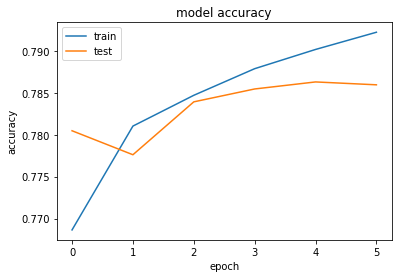

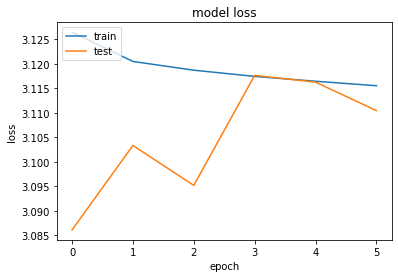

In [145]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [127]:
#custom_objects={'BinaryFocalLoss':BinaryFocalLoss, 'TokenAndPositionEmbedding':TokenAndPositionEmbedding}



In [149]:
from focal_loss import BinaryFocalLoss
from tensorflow.keras.models import load_model
model = load_model('models/swtrans.ft')

In [150]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

yhat1 = model.predict(X_test, verbose=0)

#Binary Classification
yhat=np.where(yhat1 > 0.5, 1,0)

#Mutli-class Classification
#yhat = np.argmax(yhat, axis = 1)


accuracy = accuracy_score( Y_test, yhat)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(Y_test, yhat)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Y_test, yhat1)
print('ROC AUC: %f' % auc)


Accuracy: 0.784906
Precision: 0.776457
Recall: 0.799832
F1 score: 0.787971
Cohens kappa: 0.569820
ROC AUC: 0.869522


In [151]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 'NEGATIVE'
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 'POSITIVE'

        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'

In [152]:
y_pred_1d = []
y_test_1d = list(Y_test)
scores = model.predict(X_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

ValueError: in user code:

    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py:414 call
        return self._run_internal_graph(
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\saving\saved_model\utils.py:68 return_outputs_and_add_losses
        outputs, losses = fn(*args, **kwargs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\saving\saved_model\utils.py:164 wrap_with_training_arg
        return control_flow_util.smart_cond(
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\utils\control_flow_util.py:105 smart_cond
        return tf.__internal__.smart_cond.smart_cond(
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\smart_cond.py:58 smart_cond
        return false_fn()
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\saving\saved_model\utils.py:166 <lambda>
        lambda: replace_training_and_call(False))
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\keras\saving\saved_model\utils.py:162 replace_training_and_call
        return wrapped_call(*args, **kwargs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\eager\def_function.py:885 __call__
        result = self._call(*args, **kwds)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\eager\def_function.py:924 _call
        results = self._stateful_fn(*args, **kwds)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\eager\function.py:3038 __call__
        filtered_flat_args) = self._maybe_define_function(args, kwargs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\eager\function.py:3463 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\eager\function.py:3298 _create_graph_function
        func_graph_module.func_graph_from_py_func(
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\func_graph.py:1007 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\eager\def_function.py:668 wrapped_fn
        out = weak_wrapped_fn().__wrapped__(*args, **kwds)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\saved_model\function_deserialization.py:274 restored_function_body
        return _call_concrete_function(function, inputs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\saved_model\function_deserialization.py:78 _call_concrete_function
        result = function._call_flat(tensor_inputs, function._captured_inputs)  # pylint: disable=protected-access
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\saved_model\load.py:121 _call_flat
        return super(_WrapperFunction, self)._call_flat(args, captured_inputs,
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\eager\function.py:1977 _call_flat
        flat_outputs = forward_function.call(ctx, args_with_tangents)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\eager\function.py:619 call
        outputs = functional_ops.partitioned_call(
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\functional_ops.py:1221 partitioned_call
        op = graph.create_op(op_name, args, tout, name=op_name, attrs=op_attrs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:549 new_func
        return func(*args, **kwargs)
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py:3499 create_op
        return self._create_op_internal(op_type, inputs, dtypes, input_types, name,
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\MMM\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Cannot reshape a tensor with 5120000 elements to shape [640,32] (20480 elements) for '{{node switch_13/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](layer_normalization_26/batchnorm/add_1, switch_13/Reshape/shape)' with input shapes: [8000,20,32], [2] and with input tensors computed as partial shapes: input[1] = [640,32].


In [ ]:
y_test_1d = [decode_sentiment(score, include_neutral=False) for score in y_test_1d]

In [ ]:
import itertools
from sklearn.metrics import classification_report

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    labels=['Negative','Positive']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, labels, rotation=90, fontsize=22)
    plt.yticks(tick_marks, labels, fontsize=22)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=twitter_data.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='(Area Under the Curve = {:.3f})'.format(auc_keras))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ('ROC curve')
plt.legend(loc='best')
plt.show()